In [1]:
import gc
import dill
import numpy as np
import pandas as pd
import axelrod as axl
from time import time
from pprint import pprint
import matplotlib.pyplot as plt

np.set_printoptions(precision=3)
pd.options.display.float_format = "{:,.2f}".format

# the following imports are from network / axl_utils folder
import network
from network.dqn import DQN
from network.replay import ReplayMemory
from axl_utils.nnplayer import NNplayer, State
from axl_utils.game import *

In [2]:
C = axl.Action.C
D = axl.Action.D

# config game rules
# doubled game length for some extra complexity
GAME_LEN = 20 + 1
GAME = axl.Game(r=3, s=0, t=5, p=1)
Match = set_match(game=GAME, turns=GAME_LEN)
play = set_play(Match)

### this stage will use axl.tournament function to let our DQN play against multiple strategies

Detailed documentation and more strategies can be found here: https://axelrod.readthedocs.io/en/stable/_modules/index.html

In [3]:
from axl_utils.tournament import Tournament

In [4]:
# to create a complex environment
# I'm trying to encourage provocative defection     (against cooperative strategies)
# and retaliative defection                         (against provocative)
# while at the same time punish excessive defection (against retaliative)

cooperative = (axl.Cooperator(), axl.TitFor2Tats())
provocative = (axl.Prober(), axl.Prober4(), axl.RemorsefulProber())
retaliative = (axl.TitForTat(), axl.Grudger(), axl.Punisher())
noise       = ()  #(axl.Random(), axl.Alternator())

players = [*cooperative, *provocative, *retaliative, *noise]
tournament = Tournament(players, game=GAME, turns=GAME_LEN)
results = tournament.play()

Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 139.67it/s]


In [5]:
# tournament result
# explanation of the elements can be found here: https://axelrod.readthedocs.io/en/stable/tutorials/advanced/tournament_results.html
summary = results.summarise()
headers = "Rank,Name,Median_score,Cooperation_rating,Wins,Initial_C_rate,CC_rate,CD_rate,DC_rate,DD_rate,CC_to_C_rate,CD_to_C_rate,DC_to_C_rate,DD_to_C_rate".split(',')
pd.DataFrame(map(list, summary), columns=headers)

# median score is based on normalized score, which represent the average return for each turn
# e.g. if 2 player cooperates the whole game, this should be 3.00 for both

,Rank,Name,Median_score,Cooperation_rating,Wins,Initial_C_rate,CC_rate,CD_rate,DC_rate,DD_rate,CC_to_C_rate,CD_to_C_rate,DC_to_C_rate,DD_to_C_rate
0,0,Tit For Tat,2.83,0.89,0.00,1.00,0.80,0.09,0.08,0.03,1.00,0.00,1.00,0.00
1,1,Grudger,2.60,0.67,2.00,1.00,0.65,0.02,0.08,0.25,1.00,0.00,0.00,0.00
2,2,Remorseful Prober: 0.1,2.58,0.65,3.00,1.00,0.52,0.14,0.17,0.18,0.90,0.00,0.85,0.42
3,3,Punisher,2.52,0.66,2.00,1.00,0.64,0.02,0.08,0.26,1.00,0.00,0.00,0.00
4,4,Tit For 2 Tats,2.50,0.87,0.00,1.00,0.77,0.10,0.02,0.11,1.00,0.76,1.00,0.00
5,5,Prober 4,2.40,0.50,4.00,1.00,0.24,0.26,0.30,0.20,0.35,0.34,0.75,0.71
6,6,Prober,2.38,0.36,2.00,0.00,0.23,0.13,0.26,0.38,0.80,0.54,0.77,0.00
7,7,Cooperator,2.36,1.00,0.00,1.00,0.79,0.21,0.00,0.00,1.00,1.00,0.00,0.00


In [6]:
dqn = DQN([
                    network.Flatten_layer(),
                    network.Linear_layer(GAME_LEN*2, 300),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(300, 150),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(150, 80),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(80, 40),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(40, 2),
                    ],
            ReplayMemory(8000), gamma=0.9, greedy=0.2)
p1 = NNplayer(dqn, State(GAME_LEN))
del dqn
gc.collect()

param = {"lr": 1e-4, 'batch': 32, "momentum": 0.9, "mode": "train", "eps": 1e-16, "beta":(0.9, 0.999), 
         "epoch": 0, 'optimizer': 'adam', 't': 1, 'clip': 1.0, 'regularizer': ('l2', 1e-3), "loss_fn":"mse"}

In [7]:
from random import shuffle     

def train_against(trainee, trainers, iterations=40):
    shuffle(trainers)
    for trainer in trainers:
        for _  in range(iterations):
            play(trainee, trainer, show=False)

In [8]:
train_against(p1, players)
len(p1.network.memory)      # 21(turns) * 10(# of players) * 40(iterations)

6720

In [ ]:
# train loop as usual
for _ in range(10):
    start = time()
    p1.train(30, param)
    
    train_against(p1, players)
    
    print(f'loss: {p1.network.loss},            time: +{time()-start:.2f} sec')

In [ ]:
p1.plot()
# but it seems our policy net didn't get enough training before the target net is updated
# causing the divergence we've seen in stage 1 section 2

# evident by the cyclic, overall upward trend in loss:

In [9]:
p1.network.reset()
param = {"lr": 7e-5, 'batch': 32, "momentum": 0.9, "mode": "train", "eps": 1e-16, "beta":(0.9, 0.999), 
         "epoch": 0, 'optimizer': 'adam', 't': 1, 'clip': 1.0, 'regularizer': ('l2', 1e-3), "loss_fn":"mse"}

Network reinitialized.


In [10]:
# time to take a nap
ls = []
loss_ls = []
for i in range(100):
    
    start = time()
    p1.train(250, param, loss_targ=0.02)
    
    train_against(p1, players)
    
    print(f'loss: {p1.network.loss},            time: +{time()-start:.2f} sec')
    
    # test DQN in tournament
    if i % 2 == 0:
        loss_ls.append(np.sum(p1.network.loss))
        with p1:
            p1.network.verbosity = False
            tournament = Tournament([p1, *players], game=GAME, turns=GAME_LEN)
            results = tournament.play()
            summary = results.summarise()
            ls.append(pd.DataFrame(map(list, summary), columns=headers))
               
        # backing up
        with open('data/s2/tn_results.pkl', "wb") as file:
            dill.dump(ls, file)

        with open(f'data/s2/p1_{i}.pkl', "wb") as file:
            dill.dump(p1, file)

terminated at 166 epochs
loss: [0.228 0.224],            time: +195.02 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 148.81it/s]


terminated at 99 epochs
loss: [0.249 0.306],            time: +136.85 sec
terminated at 84 epochs
loss: [0.436 0.261],            time: +117.73 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 147.06it/s]


terminated at 194 epochs
loss: [0.426 0.259],            time: +262.97 sec
terminated at 172 epochs
loss: [0.512 0.509],            time: +236.46 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 136.59it/s]


terminated at 118 epochs
loss: [0.9   0.323],            time: +163.03 sec
loss: [0.461 0.264],            time: +341.17 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 151.51it/s]


terminated at 85 epochs
loss: [0.679 0.477],            time: +119.98 sec
terminated at 95 epochs
loss: [0.699 0.716],            time: +132.82 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 158.23it/s]


terminated at 89 epochs
loss: [0.499 0.598],            time: +123.59 sec
loss: [0.653 0.397],            time: +342.31 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 139.67it/s]


loss: [0.833 0.456],            time: +340.34 sec
terminated at 131 epochs
loss: [0.618 0.731],            time: +178.66 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 150.60it/s]


terminated at 148 epochs
loss: [0.757 0.543],            time: +205.75 sec
terminated at 98 epochs
loss: [1.067 0.579],            time: +138.32 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 150.60it/s]


terminated at 99 epochs
loss: [0.663 0.445],            time: +141.44 sec
terminated at 135 epochs
loss: [0.503 0.44 ],            time: +188.94 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 150.03it/s]


terminated at 160 epochs
loss: [1.007 0.901],            time: +224.65 sec
terminated at 224 epochs
loss: [0.745 0.502],            time: +314.04 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 156.25it/s]


terminated at 180 epochs
loss: [0.843 0.359],            time: +251.47 sec
terminated at 106 epochs
loss: [0.653 0.604],            time: +151.71 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 150.60it/s]


loss: [0.796 0.573],            time: +346.69 sec
terminated at 108 epochs
loss: [0.983 0.499],            time: +152.44 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 149.70it/s]


terminated at 99 epochs
loss: [0.59  0.533],            time: +142.11 sec
terminated at 116 epochs
loss: [0.829 0.464],            time: +161.05 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 111.59it/s]


terminated at 232 epochs
loss: [1.041 0.499],            time: +325.29 sec
terminated at 115 epochs
loss: [1.154 0.582],            time: +163.34 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 154.32it/s]


terminated at 217 epochs
loss: [0.978 0.377],            time: +304.59 sec
terminated at 175 epochs
loss: [0.415 0.636],            time: +247.66 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 159.22it/s]


terminated at 171 epochs
loss: [0.764 0.414],            time: +240.95 sec
terminated at 190 epochs
loss: [0.557 0.614],            time: +273.21 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 152.44it/s]


terminated at 166 epochs
loss: [0.66  0.945],            time: +236.22 sec
terminated at 237 epochs
loss: [0.62  0.705],            time: +345.57 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 149.71it/s]


terminated at 129 epochs
loss: [1.006 0.628],            time: +187.00 sec
terminated at 129 epochs
loss: [0.697 0.472],            time: +187.98 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 144.51it/s]


terminated at 137 epochs
loss: [0.591 0.789],            time: +208.90 sec
terminated at 191 epochs
loss: [0.779 0.384],            time: +296.56 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 142.86it/s]


terminated at 93 epochs
loss: [1.115 0.471],            time: +137.47 sec
loss: [1.4   0.495],            time: +358.26 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 154.32it/s]


terminated at 137 epochs
loss: [0.688 0.981],            time: +197.86 sec
terminated at 180 epochs
loss: [0.722 0.595],            time: +260.00 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 131.58it/s]


terminated at 85 epochs
loss: [0.648 0.713],            time: +124.25 sec
terminated at 111 epochs
loss: [0.861 0.561],            time: +162.69 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 149.68it/s]


terminated at 173 epochs
loss: [0.699 0.569],            time: +251.65 sec
terminated at 139 epochs
loss: [0.757 0.811],            time: +203.88 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 148.78it/s]


terminated at 178 epochs
loss: [0.617 0.992],            time: +265.20 sec
loss: [0.446 0.646],            time: +374.32 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 137.73it/s]


loss: [0.983 0.686],            time: +373.11 sec
terminated at 87 epochs
loss: [0.587 0.777],            time: +134.25 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 142.83it/s]


loss: [0.559 0.684],            time: +366.21 sec
loss: [0.806 0.569],            time: +366.13 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 179.77it/s]


terminated at 91 epochs
loss: [1.071 0.481],            time: +135.37 sec
terminated at 209 epochs
loss: [1.036 0.44 ],            time: +308.00 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 173.62it/s]


terminated at 191 epochs
loss: [0.876 0.385],            time: +284.14 sec
loss: [0.545 0.602],            time: +364.78 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 162.34it/s]


loss: [0.721 0.394],            time: +370.12 sec
terminated at 138 epochs
loss: [0.788 0.693],            time: +207.57 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 166.63it/s]


terminated at 222 epochs
loss: [0.773 0.427],            time: +334.74 sec
terminated at 99 epochs
loss: [0.495 0.973],            time: +152.95 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 181.80it/s]


loss: [0.612 1.054],            time: +377.57 sec
loss: [0.645 0.576],            time: +380.04 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 170.04it/s]


loss: [0.495 0.723],            time: +379.61 sec
terminated at 139 epochs
loss: [0.622 0.852],            time: +213.43 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 173.61it/s]


terminated at 180 epochs
loss: [0.95  0.433],            time: +276.99 sec
terminated at 145 epochs
loss: [1.107 0.502],            time: +223.05 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 161.27it/s]


terminated at 203 epochs
loss: [0.819 0.536],            time: +308.82 sec
loss: [0.671 0.52 ],            time: +380.96 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 114.68it/s]


terminated at 94 epochs
loss: [0.507 1.43 ],            time: +146.56 sec
terminated at 106 epochs
loss: [0.524 0.826],            time: +162.94 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 162.30it/s]


loss: [0.832 0.829],            time: +382.14 sec
loss: [0.495 0.373],            time: +386.85 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 171.20it/s]


terminated at 164 epochs
loss: [0.463 0.814],            time: +258.54 sec
loss: [0.799 0.756],            time: +388.09 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 150.57it/s]


loss: [0.533 0.568],            time: +390.35 sec
loss: [0.736 0.324],            time: +389.65 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 166.63it/s]


loss: [0.449 1.183],            time: +390.35 sec
terminated at 214 epochs
loss: [1.092 0.981],            time: +338.64 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 160.22it/s]


terminated at 115 epochs
loss: [0.551 0.942],            time: +184.05 sec
terminated at 182 epochs
loss: [0.774 0.659],            time: +291.52 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 173.19it/s]


terminated at 122 epochs
loss: [1.499 0.636],            time: +198.34 sec
terminated at 100 epochs
loss: [1.189 0.538],            time: +162.94 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 152.43it/s]


terminated at 188 epochs
loss: [0.809 0.8  ],            time: +306.35 sec
terminated at 129 epochs
loss: [0.881 0.575],            time: +210.40 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 170.07it/s]


terminated at 130 epochs
loss: [0.752 0.617],            time: +212.44 sec
terminated at 178 epochs
loss: [0.707 0.663],            time: +290.22 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 177.31it/s]


loss: [0.325 0.354],            time: +405.43 sec
terminated at 208 epochs
loss: [0.95  0.452],            time: +337.63 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 178.55it/s]


terminated at 89 epochs
loss: [0.592 0.641],            time: +145.30 sec
terminated at 131 epochs
loss: [0.723 0.759],            time: +213.08 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 178.57it/s]


terminated at 143 epochs
loss: [1.313 0.583],            time: +233.25 sec
terminated at 111 epochs
loss: [0.743 0.696],            time: +188.98 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 171.15it/s]


terminated at 225 epochs
loss: [0.612 0.65 ],            time: +357.45 sec
terminated at 203 epochs
loss: [0.872 0.524],            time: +324.53 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 165.53it/s]


loss: [0.465 0.469],            time: +400.75 sec
terminated at 118 epochs
loss: [0.987 0.539],            time: +193.12 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 159.24it/s]


terminated at 89 epochs
loss: [1.411 0.533],            time: +144.89 sec
terminated at 85 epochs
loss: [1.007 0.634],            time: +139.00 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 166.68it/s]


terminated at 153 epochs
loss: [0.886 0.608],            time: +251.12 sec
loss: [0.838 0.415],            time: +408.16 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 176.06it/s]


terminated at 104 epochs
loss: [0.714 0.551],            time: +173.53 sec


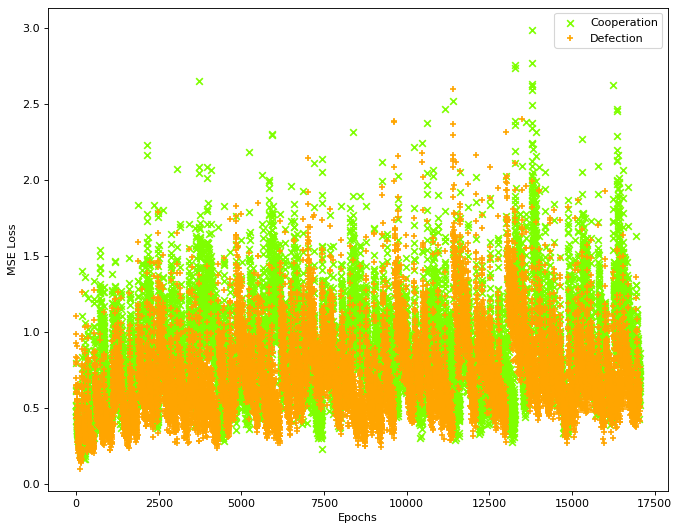

In [11]:
p1.plot()

In [13]:
with p1:
    play(p1, axl.RemorsefulProber())

[[27.429 28.712]]
[[34.354 27.181]]
[[11.592  9.87 ]]
[[26.44  26.418]]
[[22.83  26.943]]
[[24.808 22.602]]
[[25.688 26.197]]
[[22.233 21.721]]
[[24.38  18.916]]
[[12.986  9.662]]
[[20.064 19.45 ]]
[[13.656 12.72 ]]
[[22.345 15.883]]
[[11.931 12.679]]
[[10.856  8.678]]
[[10.22   9.088]]
[[7.872 9.328]]
[[4.706 5.46 ]]
[[-0.347  1.97 ]]
[[-0.258  1.247]]
[[0.384 0.384]]
[(5, 0), (0, 5), (3, 3), (3, 3), (5, 0), (0, 5), (5, 0), (0, 5), (0, 5), (3, 3), (0, 5), (0, 5), (3, 3), (5, 0), (0, 5), (3, 3), (5, 0), (1, 1), (1, 1), (1, 1)]
Player 1 score = 43
Player 2 score = 53


In [14]:
[x.set_index('Name', inplace=True) for x in ls];

In [15]:
things = ['Rank', 'Median_score', 'Cooperation_rating', 'Initial_C_rate', 'CC_to_C_rate', 'CD_to_C_rate']
pd.DataFrame([[l.loc['NNplayer',t] for t in things] for l in ls], columns=things)

,Rank,Median_score,Cooperation_rating,Initial_C_rate,CC_to_C_rate,CD_to_C_rate
0,8,2.06,0.07,0.00,0.00,0.50
1,1,2.54,0.46,1.00,0.28,0.50
2,3,2.52,0.39,0.00,0.40,0.41
3,1,2.72,0.44,1.00,0.42,0.29
4,1,2.62,0.34,0.00,0.55,0.68
5,1,2.77,0.59,1.00,0.66,0.47
6,1,2.71,0.46,1.00,0.74,0.37
7,1,2.69,0.59,1.00,0.60,0.66
8,1,2.72,0.43,1.00,0.42,0.58
9,1,2.83,0.60,1.00,0.63,0.64


In [16]:
ls[42]

,Rank,Median_score,Cooperation_rating,Wins,Initial_C_rate,CC_rate,CD_rate,DC_rate,DD_rate,CC_to_C_rate,CD_to_C_rate,DC_to_C_rate,DD_to_C_rate
Name,,,,,,,,,,,,,
NNplayer,0,2.92,0.82,7.00,1.00,0.74,0.08,0.13,0.05,0.87,0.39,0.52,0.75
Tit For Tat,1,2.84,0.91,0.00,1.00,0.83,0.08,0.07,0.02,1.00,0.00,1.00,0.00
Grudger,2,2.64,0.71,2.00,1.00,0.69,0.02,0.07,0.22,1.00,0.00,0.00,0.00
Remorseful Prober: 0.1,3,2.63,0.70,3.00,1.00,0.57,0.12,0.15,0.15,0.90,0.00,0.86,0.54
Punisher,4,2.58,0.71,2.00,1.00,0.69,0.02,0.07,0.22,1.00,0.00,0.00,0.00
Tit For 2 Tats,5,2.54,0.89,0.00,1.00,0.79,0.09,0.01,0.10,1.00,0.77,1.00,0.00
Cooperator,6,2.42,1.00,0.00,1.00,0.81,0.19,0.00,0.00,1.00,1.00,0.00,0.00
Prober,7,2.37,0.39,2.00,0.00,0.22,0.16,0.27,0.34,0.83,0.46,0.80,0.00
Prober 4,8,2.34,0.50,3.50,1.00,0.22,0.28,0.29,0.21,0.39,0.32,0.74,0.71


In [17]:
ls[11]

,Rank,Median_score,Cooperation_rating,Wins,Initial_C_rate,CC_rate,CD_rate,DC_rate,DD_rate,CC_to_C_rate,CD_to_C_rate,DC_to_C_rate,DD_to_C_rate
Name,,,,,,,,,,,,,
NNplayer,0,2.95,0.80,7.00,1.00,0.74,0.07,0.14,0.06,0.92,0.53,0.48,0.83
Tit For Tat,1,2.83,0.90,0.00,1.00,0.81,0.09,0.08,0.02,1.00,0.00,1.00,0.00
Grudger,2,2.62,0.71,2.00,1.00,0.68,0.03,0.07,0.22,1.00,0.00,0.00,0.00
Punisher,3,2.61,0.70,2.00,1.00,0.68,0.02,0.07,0.23,1.00,0.00,0.00,0.00
Remorseful Prober: 0.1,4,2.57,0.67,3.50,1.00,0.53,0.14,0.17,0.16,0.88,0.00,0.94,0.51
Tit For 2 Tats,5,2.55,0.89,0.00,1.00,0.80,0.09,0.01,0.10,1.00,0.81,1.00,0.00
Cooperator,6,2.43,1.00,0.00,1.00,0.81,0.19,0.00,0.00,1.00,1.00,0.00,0.00
Prober,7,2.40,0.41,2.00,0.00,0.27,0.14,0.25,0.33,0.83,0.49,0.80,0.00
Prober 4,8,2.25,0.50,4.00,1.00,0.22,0.28,0.27,0.23,0.36,0.34,0.72,0.72


In [26]:
with open('data/s2/p1_22.pkl', "rb") as file:
    p2 = dill.load(file)

In [27]:
with p2:
    play(p2, axl.TitForTat())

[[34.898 23.856]]
[[31.354 24.304]]
[[26.937 25.924]]
[[24.432 22.898]]
[[26.381 21.109]]
[[25.442 22.267]]
[[21.726 16.985]]
[[24.041 21.975]]
[[21.903 20.028]]
[[22.829 22.421]]
[[21.719 21.687]]
[[18.322 17.668]]
[[18.543 17.636]]
[[15.413 14.933]]
[[15.467 14.943]]
[[12.685 11.656]]
[[12.275 12.269]]
[[8.877 6.66 ]]
[[6.251 4.576]]
[[3.094 5.264]]
[[0.032 0.117]]
[(3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (5, 0)]
Player 1 score = 62
Player 2 score = 57


In [34]:
with p2:
    play(p2, axl.Prober4())

[[34.898 23.856]]
[[31.354 24.304]]
[[26.937 25.924]]
[[19.085 22.753]]
[[19.633 18.303]]
[[22.086 23.376]]
[[21.278 23.36 ]]
[[18.674 24.803]]
[[20.894 22.183]]
[[17.617 20.271]]
[[18.191 20.234]]
[[13.86  18.416]]
[[18.562 18.761]]
[[12.321 14.455]]
[[ 8.826 11.024]]
[[ 9.986 11.884]]
[[5.706 8.155]]
[[5.617 6.106]]
[[3.693 5.996]]
[[0.091 1.007]]
[[ 0.038 -0.008]]
[(3, 3), (3, 3), (0, 5), (5, 0), (0, 5), (1, 1), (1, 1), (5, 0), (5, 0), (1, 1), (5, 0), (1, 1), (5, 0), (5, 0), (1, 1), (5, 0), (1, 1), (1, 1), (5, 0), (1, 1)]
Player 1 score = 54
Player 2 score = 24


In [35]:
play(axl.TitForTat(), axl.Prober4())

[(3, 3), (3, 3), (0, 5), (5, 0), (0, 5), (1, 1), (1, 1), (5, 0), (3, 3), (0, 5), (5, 0), (0, 5), (5, 0), (3, 3), (0, 5), (5, 0), (0, 5), (1, 1), (5, 0), (0, 5)]
Player 1 score = 45
Player 2 score = 50


In [32]:
with p2:
    play(p2, axl.RemorsefulProber())

[[34.898 23.856]]
[[31.354 24.304]]
[[26.937 25.924]]
[[24.432 22.898]]
[[20.453 23.871]]
[[20.096 24.348]]
[[16.509 15.396]]
[[19.811 19.817]]
[[16.574 15.772]]
[[18.442 19.874]]
[[16.423 11.457]]
[[16.443 13.023]]
[[18.502 18.831]]
[[12.27  10.316]]
[[12.479 11.07 ]]
[[15.122 15.259]]
[[8.431 7.104]]
[[9.243 7.781]]
[[6.047 4.746]]
[[4.071 6.018]]
[[0.154 0.064]]
[(3, 3), (3, 3), (3, 3), (0, 5), (5, 0), (1, 1), (0, 5), (5, 0), (0, 5), (1, 1), (3, 3), (3, 3), (5, 0), (0, 5), (3, 3), (5, 0), (0, 5), (3, 3), (3, 3), (5, 0)]
Player 1 score = 51
Player 2 score = 51


In [36]:
with p2:
    p2.network.verbosity = False
    tournament = Tournament([p2, *players], game=GAME, turns=GAME_LEN)
    results = tournament.play()
    summary = results.summarise()

Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 126.25it/s]


In [47]:
('adam',0.9)[2]

IndexError: tuple index out of range

In [38]:
pd.DataFrame(map(list, summary), columns=headers)

,Rank,Name,Median_score,Cooperation_rating,Wins,Initial_C_rate,CC_rate,CD_rate,DC_rate,DD_rate,CC_to_C_rate,CD_to_C_rate,DC_to_C_rate,DD_to_C_rate
0,0,NNplayer,2.97,0.81,7.00,1.00,0.75,0.06,0.13,0.06,0.93,0.55,0.42,0.89
1,1,Tit For Tat,2.83,0.89,0.00,1.00,0.80,0.10,0.08,0.02,1.00,0.00,1.00,0.00
2,2,Punisher,2.62,0.71,2.00,1.00,0.69,0.02,0.07,0.22,1.00,0.00,0.00,0.00
3,3,Remorseful Prober: 0.1,2.61,0.68,3.00,1.00,0.54,0.14,0.16,0.16,0.89,0.00,0.89,0.47
4,4,Grudger,2.58,0.71,2.00,1.00,0.68,0.02,0.07,0.23,1.00,0.00,0.00,0.00
5,5,Tit For 2 Tats,2.56,0.89,0.00,1.00,0.80,0.09,0.01,0.10,1.00,0.81,1.00,0.00
6,6,Cooperator,2.43,1.00,0.00,1.00,0.81,0.19,0.00,0.00,1.00,1.00,0.00,0.00
7,7,Prober,2.40,0.41,2.00,0.00,0.27,0.14,0.25,0.33,0.83,0.49,0.80,0.00
8,8,Prober 4,2.24,0.50,4.00,1.00,0.22,0.28,0.27,0.23,0.36,0.34,0.72,0.72


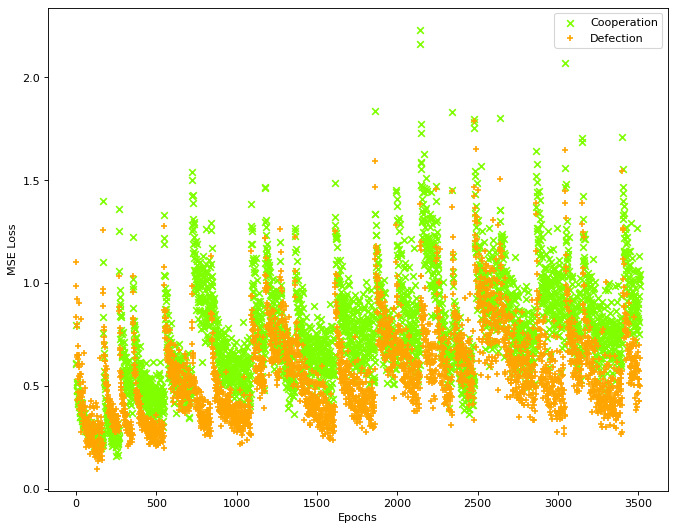

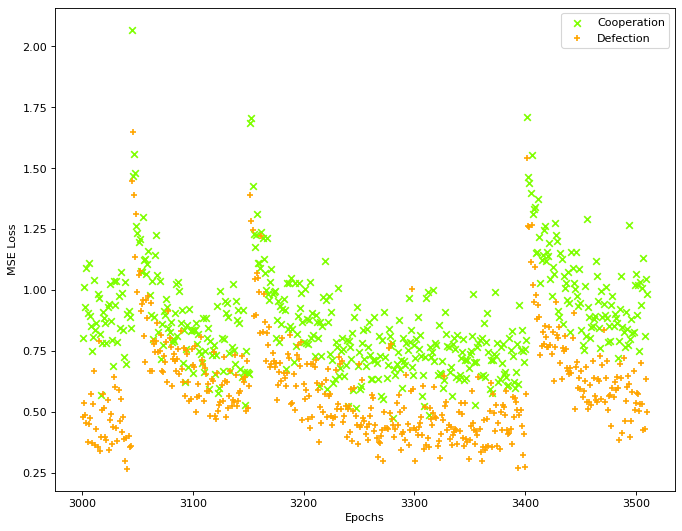

In [40]:
p2.plot()
p2.plot(min_ran=3000)